# Food Image Classification with TinyVGG
**This notebook contains:** 

- Data Visualization: Displaying sample image from custom dataset.

- Model Implementation: Implementation of the TinyVGG convolutional neural network architecture for image classification.

- Data Augmentation: Appling simple augmentation techniques to improve model generalization.

- Model Comparison: Comparing performance between a model trained on augmented data versus one trained on the original dataset.

### Imports

In [1]:
import os
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm import tqdm

### Setting up device agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Getting data

In [3]:
zip_data = Path('../data/processed/baklava_churros_cheesecake.zip')
extracted_data = Path('../data/processed/baklava_churros_cheesecake')

with zipfile.ZipFile(zip_data, 'r') as zip:
    print('Unzipping dataset')
    zip.extractall(extracted_data)

Unzipping dataset


### Visualizing an image

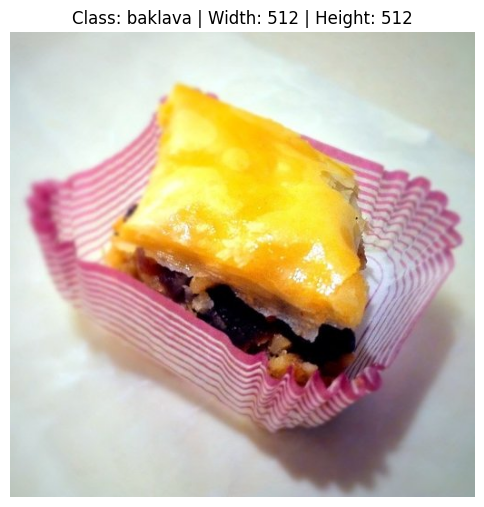

In [4]:
image_paths_list = list(extracted_data.glob('*/*/*.jpg'))
image_path = image_paths_list[0]
image_class = image_path.parent.stem

img = Image.open(image_path)
img_as_array = np.asarray(img)

plt.figure(figsize=(6, 8))
plt.imshow(img_as_array)
plt.title(f'Class: {image_class} | Width: {img.width} | Height: {img.height}')
plt.axis(False)
plt.show()

### Transforming data

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

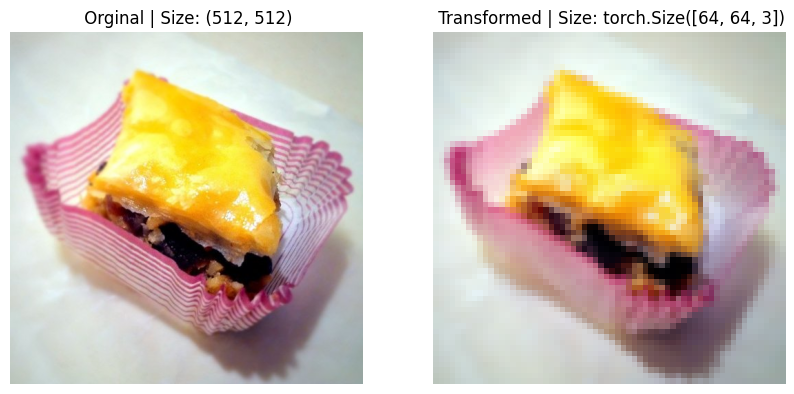

In [6]:
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.imshow(img_as_array)
plt.title(f' Orginal | Size: {img.width, img.height}')
plt.axis(False)

plt.subplot(1, 2, 2)
# (PyTorch is [C, H, W] but Matplotlib is [H, W, C])
tranformed_image = data_transform(img).permute(1, 2, 0)
plt.imshow(tranformed_image)
plt.title(f' Transformed | Size: {tranformed_image.shape}')
plt.axis(False)

plt.show()

### Loading data using ImageFolder

In [7]:
train_dir = Path('../data/processed/baklava_churros_cheesecake/train')
test_dir = Path('../data/processed/baklava_churros_cheesecake/test')

In [8]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f'Train data:\n{train_data}')
print(f'Test data:\n{test_data}')

Train data:
Dataset ImageFolder
    Number of datapoints: 2250
    Root location: ..\data\processed\baklava_churros_cheesecake\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 750
    Root location: ..\data\processed\baklava_churros_cheesecake\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


### Exploring data

In [9]:
class_names = train_data.classes
class_names

['baklava', 'cheesecake', 'churros']

In [10]:
img = train_data[0][0]
label = train_data[0][1]

print(f'Image tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')

Image tensor:
tensor([[[0.5490, 0.5608, 0.5647,  ..., 0.2353, 0.2196, 0.1843],
         [0.5686, 0.5725, 0.5490,  ..., 0.2314, 0.2118, 0.1882],
         [0.5765, 0.5725, 0.5647,  ..., 0.2157, 0.2078, 0.1804],
         ...,
         [0.4471, 0.7216, 0.8588,  ..., 0.3333, 0.3686, 0.4118],
         [0.2706, 0.3804, 0.5961,  ..., 0.4118, 0.4471, 0.4471],
         [0.2745, 0.3137, 0.3647,  ..., 0.4353, 0.5137, 0.4863]],

        [[0.4824, 0.5020, 0.4902,  ..., 0.0039, 0.0078, 0.0078],
         [0.4941, 0.5020, 0.4745,  ..., 0.0078, 0.0078, 0.0078],
         [0.5176, 0.5020, 0.4902,  ..., 0.0078, 0.0118, 0.0078],
         ...,
         [0.5020, 0.8039, 0.9647,  ..., 0.2784, 0.3216, 0.3686],
         [0.2275, 0.3608, 0.6392,  ..., 0.3529, 0.4039, 0.3961],
         [0.2196, 0.2784, 0.3412,  ..., 0.3804, 0.4941, 0.4471]],

        [[0.3490, 0.3686, 0.3529,  ..., 0.0078, 0.0078, 0.0078],
         [0.3686, 0.3765, 0.3412,  ..., 0.0078, 0.0039, 0.0078],
         [0.3843, 0.3725, 0.3569,  ..., 0.00

### Loading images into DataLoaders

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

In [12]:
img_batch, label_batch = next(iter(train_dataloader))

print(f'Batch shape: {img_batch.shape}')
print(f'Label shape: {label_batch.shape}')

Batch shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


### Model 0: TinyVGG

#### Creating model class

In [13]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))

In [14]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

#### Summary of a model

In [15]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

#### Testing model on single image

In [16]:
img, label = img_batch[0].unsqueeze(dim=0), label_batch[0]

model_0.eval()
with torch.inference_mode():
    pred = model_0(img.to(device))

print(f'Logits:\n{pred}')
print(f'Prediction probabilities:\n{torch.softmax(pred, dim=1)}')
print(f'Prediciton label: {torch.argmax(torch.softmax(pred, dim=1))}')
print(f'Actual label: {label}')

Logits:
tensor([[0.0690, 0.0654, 0.0397]])
Prediction probabilities:
tensor([[0.3370, 0.3358, 0.3272]])
Prediciton label: 0
Actual label: 0


#### Adding accuracy function

In [ ]:
def accuracy_fn(
        y_true: torch.Tensor,
        y_pred: torch.Tensor
) -> float:
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true: Truth labels for predictions.
        y_pred: Predictions to be compared to truth predictions.

    Returns:
        Accuracy value between y_true and y_pred.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

#### Creating training and testing loops

In [ ]:
def train_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        accuracy_fn: callable,
        device: torch.device = device
) -> tuple[float, float]:
    """Perform a single training step (one full pass over the training data).

    Args:
        model: The neural network model to be trained.
        data_loader: DataLoader providing the training dataset in batches.
        loss_fn: Loss function used to compute the error between predictions and targets.
        optimizer: Optimizer used to update model parameters.
        accuracy_fn: Function to calculate accuracy. 
            Should accept `y_true` (labels) and `y_pred` (predicted labels).
        device: Target device to run computations on (e.g., 'cpu' or 'cuda').

    Returns:
        Average training loss over all batches and average training accuracy over all batches.
    """
    train_loss, train_acc = 0, 0
    
    model.train()
    for X, y in data_loader:
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    return train_loss, train_acc

In [ ]:
def test_step(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        accuracy_fn: callable,
        device: torch.device = device
) -> tuple[float, float]:
    """Perform a single evaluation step (one full pass over the test/validation data).

    Args:
        model: The neural network model to be evaluated.
        data_loader: DataLoader providing the test/validation dataset in batches.
        loss_fn: Loss function used to compute the error between predictions and targets.
        accuracy_fn: Function to calculate accuracy. 
            Should accept `y_true` (labels) and `y_pred` (predicted labels).
        device: Target device to run computations on (e.g., 'cpu' or 'cuda').

    Returns:
        Average test loss over all batches and average test accuracy over all batches.
    """
    test_loss, test_acc = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss
            test_acc += accuracy_fn(y_true=y,
                                     y_pred=test_pred.argmax(dim=1))

        # Adjust metrics to get average loss and accuracy
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        return test_loss, test_acc

In [ ]:
def train(
        model: torch.nn.Module, 
        train_dataloader: torch.utils.data.DataLoader, 
        test_dataloader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        accuracy_fn: callable,
        epochs: int
) -> dict[str, list[float]]:
    """Train and evaluate a PyTorch model over multiple epochs.

    Runs the training loop using `train_step` and evaluation loop using `test_step`
    for a specified number of epochs. Tracks and returns loss and accuracy metrics
    for both training and testing.

    Args:
        model: The neural network model to be trained and evaluated.
        train_dataloader: DataLoader providing the training dataset in batches.
        test_dataloader: DataLoader providing the test/validation dataset in batches.
        optimizer: Optimizer used to update model parameters based on gradients.
        loss_fn: Loss function used to compute the error between predictions and targets.
        accuracy_fn: Function to calculate accuracy. 
            Should accept `y_true` (labels) and `y_pred` (predicted labels).
        epochs: Number of epochs (full passes through the training dataset).

    Returns:
        A dictionary containing per-epoch metrics.
    """
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn)
        
        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        
        print(
            f'Epoch: {epoch+1} | '
            f'train_loss: {train_loss:.4f} | '
            f'train_acc: {train_acc:.4f} | '
            f'test_loss: {test_loss:.4f} | '
            f'test_acc: {test_acc:.4f}'
        )

        results['train_loss'].append(train_loss.item() if hasattr(train_loss, 'item') else train_loss)
        results['train_acc'].append(train_acc.item() if hasattr(train_acc, 'item') else train_acc)
        results['test_loss'].append(test_loss.item() if hasattr(test_loss, 'item') else test_loss)
        results['test_acc'].append(test_acc.item() if hasattr(test_acc, 'item') else test_acc)

    return results

#### Setup loss function and optimizer

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

#### Train and Evaluate model

In [22]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time: {end_time-start_time:.2f} seconds')

 20%|██        | 1/5 [00:32<02:11, 32.97s/it]

Epoch: 1 | train_loss: 1.1020 | train_acc: 33.2218 | test_loss: 1.0988 | test_acc: 32.5521


 40%|████      | 2/5 [00:59<01:27, 29.30s/it]

Epoch: 2 | train_loss: 1.0990 | train_acc: 32.9137 | test_loss: 1.0983 | test_acc: 34.8958


 60%|██████    | 3/5 [01:26<00:56, 28.00s/it]

Epoch: 3 | train_loss: 1.0933 | train_acc: 37.5528 | test_loss: 1.0692 | test_acc: 44.7917


 80%|████████  | 4/5 [01:51<00:26, 26.95s/it]

Epoch: 4 | train_loss: 1.0475 | train_acc: 44.7183 | test_loss: 0.9885 | test_acc: 52.8646


100%|██████████| 5/5 [02:18<00:00, 27.68s/it]

Epoch: 5 | train_loss: 1.0200 | train_acc: 49.2694 | test_loss: 0.9904 | test_acc: 50.8557
Total training time: 138.42 seconds


#### Plot the loss curves

In [ ]:
def plot_loss_curves_and_accuracy(results: dict[str, list[float]]) -> None:
    """Plot training and test loss and accuracy curves.

    Args:
        results: A dictionary containing the results of training with the following keys:
            - 'train_loss': List of training losses per epoch.
            - 'test_loss': List of test losses per epoch.
            - 'train_acc': List of training accuracies per epoch.
            - 'test_acc': List of test accuracies per epoch.

    Returns:
        None. Displays two subplots:
            - Left: Training and test loss curves.
            - Right: Training and test accuracy curves.
    """
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

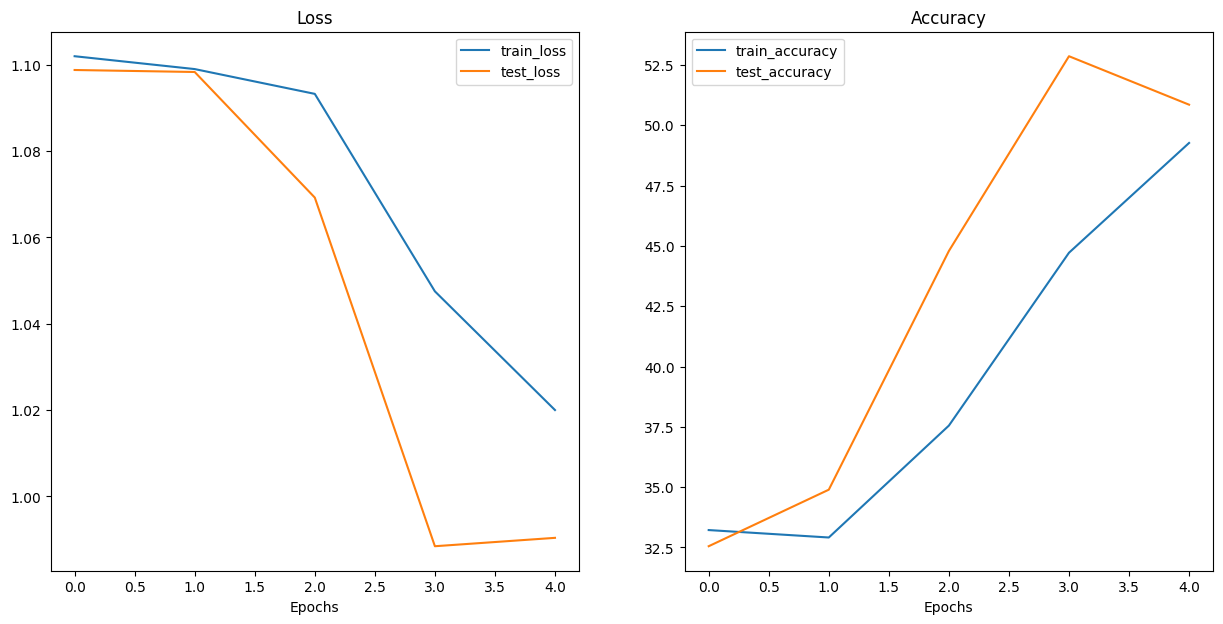

In [24]:
plot_loss_curves_and_accuracy(model_0_results)

### Model 1: TinyVGG with data augmentation

#### Data transform with augmentation

In [25]:
train_transform_augmentation = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

#### Creating train and test DataLoaders

In [26]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform_augmentation)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

print(f'Train data with augmentation:\n{train_data_augmented}')
print(f'Test data:\n{test_data}')

Train data with augmentation:
Dataset ImageFolder
    Number of datapoints: 2250
    Root location: ..\data\processed\baklava_churros_cheesecake\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 750
    Root location: ..\data\processed\baklava_churros_cheesecake\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [27]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

#### Create and train model 1

In [28]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [30]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

from timeit import default_timer as timer 
start_time = timer()

model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time: {end_time-start_time:.2f} seconds')

 20%|██        | 1/5 [00:28<01:53, 28.38s/it]

Epoch: 1 | train_loss: 1.1018 | train_acc: 32.7377 | test_loss: 1.0976 | test_acc: 36.5885


 40%|████      | 2/5 [00:55<01:22, 27.62s/it]

Epoch: 2 | train_loss: 1.0983 | train_acc: 34.7711 | test_loss: 1.0899 | test_acc: 44.6987


 60%|██████    | 3/5 [01:22<00:54, 27.49s/it]

Epoch: 3 | train_loss: 1.0957 | train_acc: 36.3468 | test_loss: 1.0985 | test_acc: 33.9844


 80%|████████  | 4/5 [01:49<00:27, 27.28s/it]

Epoch: 4 | train_loss: 1.0848 | train_acc: 40.4930 | test_loss: 1.0302 | test_acc: 48.1771


100%|██████████| 5/5 [02:16<00:00, 27.32s/it]

Epoch: 5 | train_loss: 1.0430 | train_acc: 46.8310 | test_loss: 0.9879 | test_acc: 50.6510
Total training time: 136.60 seconds


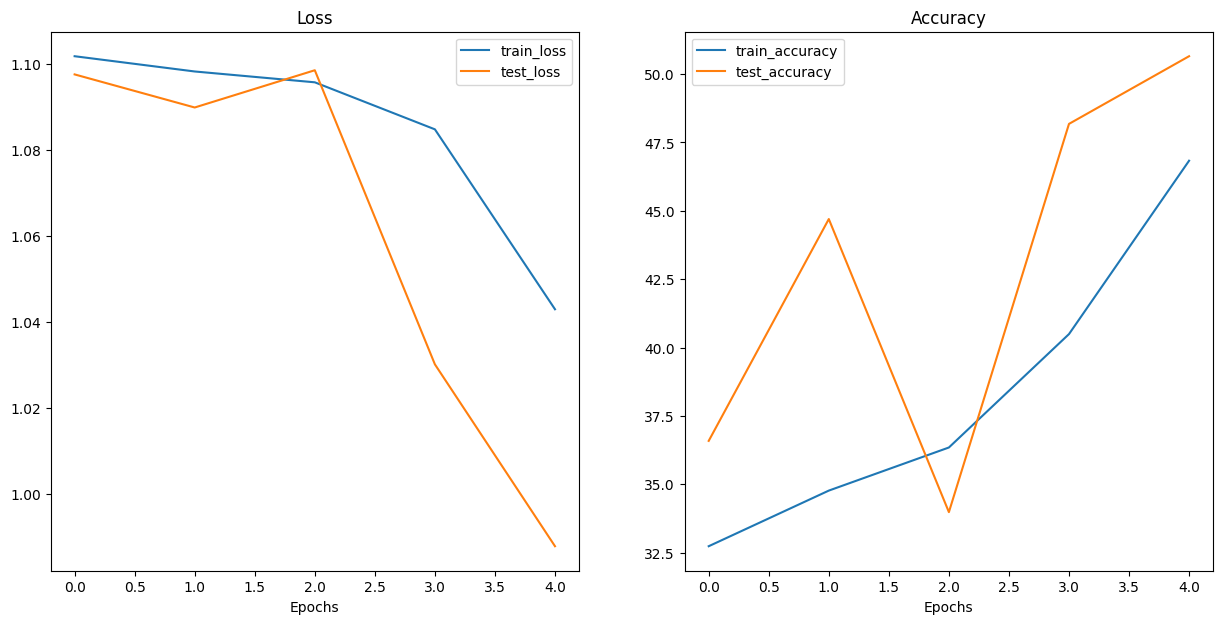

In [31]:
plot_loss_curves_and_accuracy(model_1_results)

### Compare model results

In [34]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.101992,33.221831,1.098801,32.552083
1,1.099013,32.913732,1.098338,34.895833
2,1.093268,37.552817,1.069239,44.791667
3,1.047513,44.718310,0.988455,52.864583
4,1.020009,49.269366,0.990396,50.855655


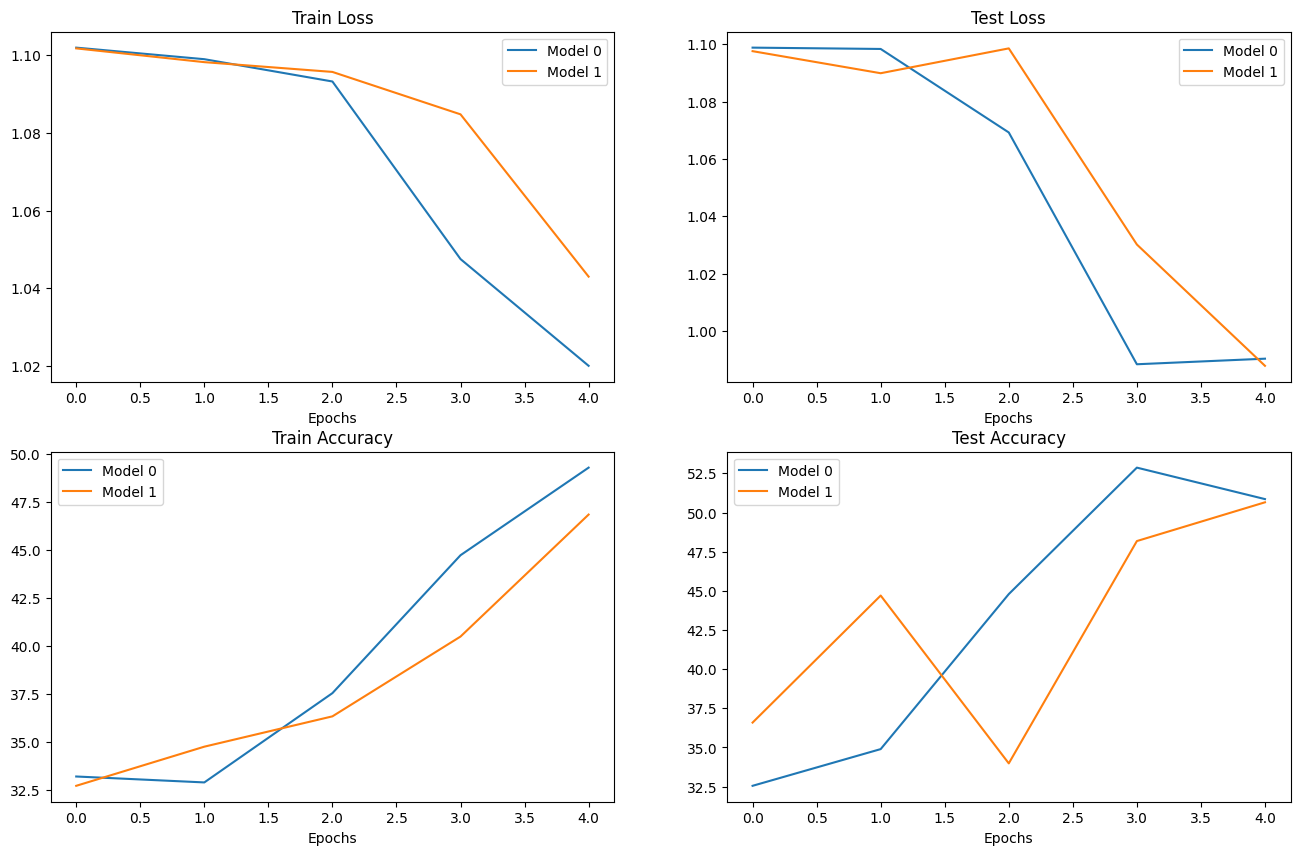

In [38]:
plt.figure(figsize=(16, 10))

epochs = range(len(model_0_df))

# Train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();